### Import packages

In [1]:
import pandas as pd
import numpy as np
import mlforecast
import lightgbm as lgb
from matplotlib import pyplot as plt
import optuna
import plotly_express as px
import seaborn as sns
import os
import gc
import warnings
import statsmodels.api as sm

c:\Users\felsp\anaconda3\envs\forecasting\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Import and analyse main datasets

#### Train Dataset

In [2]:
train = pd.read_parquet("../data/store_sales/train.parquet")
print(train.info())
print(train.describe())
display(train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB
None
                 id     store_nbr         sales   onpromotion
count  3.000888e+06  3.000888e+06  3.000888e+06  3.000888e+06
mean   1.500444e+06  2.750000e+01  3.577757e+02  2.602770e+00
std    8.662819e+05  1.558579e+01  1.101998e+03  1.221888e+01
min    0.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00
25%    7.502218e+05  1.400000e+01  0.000000e+00  0.000000e+00
50%    1.500444e+06  2.750000e+01  1.100000e+01  0.000000e+00
75%    2.250665e+06  4.100000e+01  1.958473e+02  0.000000e+00
max    3.000887e+06  5.400000e+01  1.247170e+05  7.410000e+02


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


#### Test Dataset

In [3]:
test = pd.read_parquet("../data/store_sales/test.parquet")
print(test.info())
print(test.describe())
display(test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   date         28512 non-null  object
 2   store_nbr    28512 non-null  int64 
 3   family       28512 non-null  object
 4   onpromotion  28512 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB
None
                 id     store_nbr   onpromotion
count  2.851200e+04  28512.000000  28512.000000
mean   3.015144e+06     27.500000      6.965383
std    8.230850e+03     15.586057     20.683952
min    3.000888e+06      1.000000      0.000000
25%    3.008016e+06     14.000000      0.000000
50%    3.015144e+06     27.500000      0.000000
75%    3.022271e+06     41.000000      6.000000
max    3.029399e+06     54.000000    646.000000


,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1
28508,3029396,2017-08-31,9,PREPARED FOODS,0
28509,3029397,2017-08-31,9,PRODUCE,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9


### Change date column to datetime

In [4]:
train["date"] = pd.to_datetime(train.date)
test["date"] = pd.to_datetime(test.date)

### Analysis of Sales in different time scales

#### Daily sales over time as a bar plot

In [5]:
px.bar(train.groupby("date").agg({"sales": "sum"}).reset_index(), x="date", y="sales", title="Sales over time")

# should be the code for matplotlib --> to be tested

# # Group by date and sum the sales
# sales_over_time = train.groupby("date")["sales"].sum()

# # Extract the date index and sales values
# dates = sales_over_time.index
# sales = sales_over_time.values

# # Create a bar plot
# plt.figure(figsize=(10, 6))
# plt.bar(dates, sales, color='blue')

# # Set labels and title
# plt.xlabel('Date')
# plt.ylabel('Sales')
# plt.title('Sales over time')

# # Rotate x-axis labels for better readability (if necessary)
# plt.xticks(rotation=45, ha='right')

# # Show the plot
# plt.tight_layout()
# plt.show()


#### Daily sales over time as line plot

In [ ]:
px.line(train.groupby("date").agg({"sales": "sum"}).reset_index(), x="date", y="sales", title="Sales over time")

# should be the matplotlib code --> to be tested

#### Weekly sales per store

In [7]:
weekly_sales = train.set_index("date").groupby("store_nbr").resample("W").agg({"sales": "sum"}).reset_index()
px.line(weekly_sales, x="date", y="sales", color="store_nbr", title="Weekly sales per store")

#### Monthly sales per store

In [8]:
monthly_sales = train.set_index("date").groupby("store_nbr").resample("M").agg({"sales": "sum"}).reset_index()
px.line(monthly_sales, x="date", y="sales", color="store_nbr", title="Monthly sales per store")

#### Yearly sales summed up by store

In [9]:
yearly_sales = train.set_index("date").groupby("store_nbr").resample("Y").agg({"sales": "sum"}).reset_index()
px.bar(yearly_sales, x="date", y="sales", title="Yearly sales per store")

### Info about stores dataset

In [10]:
stores = pd.read_parquet("../data/store_sales/stores.parquet")
print(stores.info())
print(stores.describe())
display(stores.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB
None
       store_nbr    cluster
count  54.000000  54.000000
mean   27.500000   8.481481
std    15.732133   4.693395
min     1.000000   1.000000
25%    14.250000   4.000000
50%    27.500000   8.500000
75%    40.750000  13.000000
max    54.000000  17.000000


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


### Merge information on stores with train data

In [11]:
merged_train = pd.merge(train, stores, on="store_nbr")
print(merged_train.isnull().sum())
print(merged_train.info())
display(merged_train)

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
city           0
state          0
type           0
cluster        0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 10 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
 6   city         object        
 7   state        object        
 8   type         object        
 9   cluster      int64         
dtypes: datetime64[ns](1), float64(1), int64(4), object(4)
memory usage: 228.9+ MB
None


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.000,0,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.000,0,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.000,0,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.000,0,Quito,Pichincha,D,13
...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,Quito,Pichincha,B,6
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Quito,Pichincha,B,6
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,Quito,Pichincha,B,6
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Quito,Pichincha,B,6


#### Bar plot of total sales per city

In [12]:
px.bar(merged_train.groupby("city").agg({"sales": "sum"}).reset_index(), x="city", y="sales", title="Sales per city")

### Analysis of transactions per store per day

In [13]:
transactions = pd.read_parquet("../data/store_sales/transactions.parquet").sort_values(["store_nbr", "date"])
transactions["date"] = pd.to_datetime(transactions.date)
print(transactions["transactions"].max)
print(transactions.info())
display(transactions)

<bound method Series.max of 1        2111
47       1833
93       1863
139      1509
185       520
         ... 
83271     768
83325     903
83379    1054
83433     818
83487     802
Name: transactions, Length: 83488, dtype: int64>
<class 'pandas.core.frame.DataFrame'>
Index: 83488 entries, 1 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 2.5 MB
None


,date,store_nbr,transactions
1,2013-01-02,1,2111
47,2013-01-03,1,1833
93,2013-01-04,1,1863
139,2013-01-05,1,1509
185,2013-01-06,1,520
...,...,...,...
83271,2017-08-11,54,768
83325,2017-08-12,54,903
83379,2017-08-13,54,1054
83433,2017-08-14,54,818


#### Total transactions per store

In [14]:
px.bar(transactions.groupby("store_nbr").agg({"transactions": "sum"}).reset_index(), x="store_nbr", y="transactions", title="Transactions per store")

#### Transactions per store per month

In [15]:
transactions_temp = transactions.set_index("date").groupby("store_nbr").resample("M").agg({"transactions": "sum"}).reset_index()
px.line(transactions_temp, x="date", y="transactions", title="Transactions per store", color="store_nbr")

### Merging transactions with train

In [16]:

transactions_merged_train = pd.merge(merged_train.sort_values(["date", "store_nbr"]), transactions, on=["date", "store_nbr"], how = "left")
print(transactions_merged_train.isnull().sum())
print(transactions_merged_train.info())

id                   0
date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
city                 0
state                0
type                 0
cluster              0
transactions    245784
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 11 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            int64         
 1   date          datetime64[ns]
 2   store_nbr     int64         
 3   family        object        
 4   sales         float64       
 5   onpromotion   int64         
 6   city          object        
 7   state         object        
 8   type          object        
 9   cluster       int64         
 10  transactions  float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(4)
memory usage: 251.8+ MB
None


#### Filling days with 0 total sales with 0 transactions

In [17]:
transactions_merged_train['total_sales'] = transactions_merged_train.groupby(['date', 'store_nbr'])['sales'].transform('sum')
transactions_merged_train.loc[transactions_merged_train['total_sales'] == 0, 'transactions'] = transactions_merged_train.loc[transactions_merged_train['total_sales'] == 0, 'transactions'].fillna(0)
print(f"NaN Values in Column transactions: {transactions_merged_train['transactions'].isnull().sum()}")

NaN Values in Column transactions: 3894


#### Calculating ratio between total sales and transactions on a day

In [18]:
transactions_merged_train['sales_transactions_ratio'] = transactions_merged_train['total_sales'] / transactions_merged_train['transactions']
median_value = transactions_merged_train['sales_transactions_ratio'].median()
print(f"Median ratio between sales and transactions: {median_value}")

Median ratio between sales and transactions: 7.156389264410902


#### Dividing total sales on a day with NaN transaction values by median ratio

In [19]:
transactions_merged_train['transactions'] = transactions_merged_train['transactions'].fillna(transactions_merged_train['total_sales'] / median_value)
transactions_merged_train['transactions'] = transactions_merged_train['transactions'].astype(int)
print(f"NaN Values in Column transactions: {transactions_merged_train['transactions'].isnull().sum()}")

NaN Values in Column transactions: 0


#### Dropping helper columns

In [20]:
transactions_merged_train = transactions_merged_train.drop(columns=["total_sales", "sales_transactions_ratio"])

### Analysis of USD to EURO Exchange rate dataset 

In [21]:
currency_parquet = pd.read_parquet('../data/forex.parquet')
currency_parquet["date"] = pd.to_datetime(currency_parquet["date"])
print(currency_parquet.info())
display(currency_parquet)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1453035 entries, 0 to 1453034
Data columns (total 7 columns):
 #   Column    Non-Null Count    Dtype         
---  ------    --------------    -----         
 0   slug      1453035 non-null  object        
 1   date      1453035 non-null  datetime64[ns]
 2   open      1453035 non-null  float64       
 3   high      1453035 non-null  float64       
 4   low       1453035 non-null  float64       
 5   close     1453035 non-null  float64       
 6   currency  1453035 non-null  object        
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 77.6+ MB
None


,slug,date,open,high,low,close,currency
0,GBP/EGP,2001-04-10,5.580900,5.594700,5.594700,5.594700,EGP
1,GBP/EGP,2001-06-04,5.475170,5.493900,5.493900,5.493900,EGP
2,GBP/EGP,2001-08-01,5.679900,5.654300,5.654300,5.654300,EGP
3,GBP/EGP,2002-07-29,7.217000,7.217000,7.217000,7.217000,EGP
4,GBP/EGP,2003-01-02,7.424290,7.389900,7.389900,7.389900,EGP
...,...,...,...,...,...,...,...
1453030,USD/MXN,2021-08-24,20.317129,20.360830,20.238400,20.317949,MXN
1453031,USD/MXN,2021-08-25,20.202400,20.347589,20.160601,20.206100,MXN
1453032,USD/MXN,2021-08-26,20.228861,20.384501,20.211901,20.216101,MXN
1453033,USD/MXN,2021-08-27,20.369301,20.423140,20.191200,20.366501,MXN


#### Selecting USD as it is the currency of Ecuador

In [22]:
us_currency = currency_parquet[currency_parquet['currency'] == 'USD']
print(us_currency.shape)

(46937, 7)


#### Selecting dates relevant for train dataset

In [23]:
filtered_us_currency = us_currency[(us_currency['date'] >= transactions_merged_train["date"].min()) & (us_currency['date'] <= transactions_merged_train['date'].max())].reset_index(drop=True)
print(filtered_us_currency.shape)

(13247, 7)


#### Selecting rows with exchange rate between EUR and USD

In [24]:
final_us_currency = filtered_us_currency[filtered_us_currency['slug'] == 'EUR/USD'].drop(['slug', "currency"], axis=1).reset_index(drop=True)
final_us_currency = final_us_currency.rename(columns={"open": "slug_eur_usd_open", "high": "slug_eur_usd_high", "low": "slug_eur_usd_low", "close": "slug_eur_usd_close"})
display(final_us_currency)

,date,slug_eur_usd_open,slug_eur_usd_high,slug_eur_usd_low,slug_eur_usd_close
0,2013-01-01,1.320132,1.322401,1.319592,1.320132
1,2013-01-02,1.319784,1.329805,1.319435,1.319784
2,2013-01-03,1.318392,1.318913,1.308900,1.318218
3,2013-01-04,1.303101,1.306380,1.300052,1.303271
4,2013-01-07,1.306848,1.309929,1.302060,1.306745
...,...,...,...,...,...
1199,2017-08-09,1.175337,1.176028,1.169235,1.175461
1200,2017-08-10,1.176471,1.176471,1.170467,1.176152
1201,2017-08-11,1.176997,1.183180,1.174922,1.177024
1202,2017-08-14,1.182634,1.183999,1.177329,1.182550


#### Merging with train dataset

In [25]:
exchange_merged_train = transactions_merged_train.merge(final_us_currency, how="left", on="date")
print(exchange_merged_train.isnull().sum())

id                         0
date                       0
store_nbr                  0
family                     0
sales                      0
onpromotion                0
city                       0
state                      0
type                       0
cluster                    0
transactions               0
slug_eur_usd_open     860706
slug_eur_usd_high     860706
slug_eur_usd_low      860706
slug_eur_usd_close    860706
dtype: int64


#### Filling missing values on weekends using forward fill

In [26]:
exchange_merged_train = exchange_merged_train.ffill()
print(exchange_merged_train.isnull().sum())

id                    0
date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
city                  0
state                 0
type                  0
cluster               0
transactions          0
slug_eur_usd_open     0
slug_eur_usd_high     0
slug_eur_usd_low      0
slug_eur_usd_close    0
dtype: int64


### Analysis of General Inflation in Ecuador per year

In [27]:
global_inflation_df = pd.read_csv('../data/global_inflation_data.csv')
print(global_inflation_df.info())
display(global_inflation_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196 entries, 0 to 195
Data columns (total 47 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   country_name    196 non-null    object 
 1   indicator_name  196 non-null    object 
 2   1980            140 non-null    float64
 3   1981            144 non-null    float64
 4   1982            145 non-null    float64
 5   1983            145 non-null    float64
 6   1984            145 non-null    float64
 7   1985            145 non-null    float64
 8   1986            145 non-null    float64
 9   1987            147 non-null    float64
 10  1988            147 non-null    float64
 11  1989            147 non-null    float64
 12  1990            150 non-null    float64
 13  1991            155 non-null    float64
 14  1992            158 non-null    float64
 15  1993            169 non-null    float64
 16  1994            171 non-null    float64
 17  1995            172 non-null    flo

,country_name,indicator_name,1980,1981,1982,1983,1984,1985,1986,1987,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Afghanistan,Annual average inflation (consumer prices) rate,13.4,22.2,18.2,15.9,20.4,8.7,-2.1,18.4,...,-0.66,4.38,4.98,0.63,2.3,5.44,5.06,13.71,9.1,NaN
1,Albania,Annual average inflation (consumer prices) rate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.90,1.30,2.00,2.00,1.4,1.60,2.00,6.70,4.8,4.0
2,Algeria,Annual average inflation (consumer prices) rate,9.7,14.6,6.6,7.8,6.3,10.4,14.0,5.9,...,4.80,6.40,5.60,4.30,2.0,2.40,7.20,9.30,9.0,6.8
3,Andorra,Annual average inflation (consumer prices) rate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.10,-0.40,2.60,1.00,0.5,0.10,1.70,6.20,5.2,3.5
4,Angola,Annual average inflation (consumer prices) rate,46.7,1.4,1.8,1.8,1.8,1.8,1.8,1.8,...,9.20,30.70,29.80,19.60,17.1,22.30,25.80,21.40,13.1,22.3


### Selecting only values for Ecuador

In [28]:
global_inflation_df = global_inflation_df[global_inflation_df['country_name'] == 'Ecuador']

#### Fixing Dataset by switching index/headers

In [29]:
display(global_inflation_df.head())
global_inflation_df = global_inflation_df.transpose()
global_inflation_df = global_inflation_df.iloc[2:]
global_inflation_df = global_inflation_df.reset_index()
global_inflation_df.columns = ['date', 'inflation_ecuador']
global_inflation_df["date"] = pd.to_datetime(global_inflation_df["date"])
display(global_inflation_df.head())

,country_name,indicator_name,1980,1981,1982,1983,1984,1985,1986,1987,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
50,Ecuador,Annual average inflation (consumer prices) rate,13.0,16.4,16.3,48.4,31.2,28.0,23.0,29.5,...,4.0,1.7,0.4,-0.2,0.3,-0.3,0.1,3.5,2.3,1.8


,date,inflation_ecuador
0,1980-01-01,13.0
1,1981-01-01,16.4
2,1982-01-01,16.3
3,1983-01-01,48.4
4,1984-01-01,31.2


#### Selecting only relevant date range

In [30]:
global_inflation_df = global_inflation_df[(global_inflation_df['date'] >= exchange_merged_train["date"].min()) & (global_inflation_df['date'] <= exchange_merged_train['date'].max())] 
global_inflation_df = global_inflation_df.reset_index(drop=True)
display(global_inflation_df.head()) 

,date,inflation_ecuador
0,2013-01-01,2.7
1,2014-01-01,3.6
2,2015-01-01,4.0
3,2016-01-01,1.7
4,2017-01-01,0.4


#### Merging dataframe with train

In [31]:
ecuador_inflation_merged_train = exchange_merged_train.merge(global_inflation_df, how="left", on="date")
print(ecuador_inflation_merged_train.isnull().sum())
print(ecuador_inflation_merged_train.info())

id                          0
date                        0
store_nbr                   0
family                      0
sales                       0
onpromotion                 0
city                        0
state                       0
type                        0
cluster                     0
transactions                0
slug_eur_usd_open           0
slug_eur_usd_high           0
slug_eur_usd_low            0
slug_eur_usd_close          0
inflation_ecuador     2991978
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 16 columns):
 #   Column              Dtype         
---  ------              -----         
 0   id                  int64         
 1   date                datetime64[ns]
 2   store_nbr           int64         
 3   family              object        
 4   sales               float64       
 5   onpromotion         int64         
 6   city                object        
 7   state               object   

#### Filling all NaN values in column with forward fill

In [32]:
ecuador_inflation_merged_train = ecuador_inflation_merged_train.ffill()
print(f"NaN values in column inflation_ecuador: {ecuador_inflation_merged_train['inflation_ecuador'].isnull().sum()}")

NaN values in column inflation_ecuador: 0


### Analysis of USD inflation per month

In [33]:
usd_inflation_df = pd.read_csv('../data/inflation_per_month.csv')
usd_inflation_df["date"] = pd.to_datetime(usd_inflation_df["DATE"])
usd_inflation_df = usd_inflation_df.drop(["DATE"], axis=1)
usd_inflation_df = usd_inflation_df.rename(columns={"CPIUFDNS_PC1": "inflation_usd"})
print(usd_inflation_df.info())
display(usd_inflation_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1310 entries, 0 to 1309
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   inflation_usd  1310 non-null   float64       
 1   date           1310 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 20.6 KB
None


,inflation_usd,date
0,6.18557,1914-01-01
1,4.16667,1914-02-01
2,2.08333,1914-03-01
3,-1.03093,1914-04-01
4,1.04167,1914-05-01


#### Selecting relevant date range

In [34]:
usd_inflation_df = usd_inflation_df[(usd_inflation_df['date'] >= ecuador_inflation_merged_train["date"].min()) & (usd_inflation_df['date'] <= ecuador_inflation_merged_train['date'].max())]
usd_inflation_df = usd_inflation_df.reset_index(drop=True)
print(usd_inflation_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   inflation_usd  56 non-null     float64       
 1   date           56 non-null     datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.0 KB
None


#### Merging dataframe with train

In [35]:
usd_inflation_merged_train = ecuador_inflation_merged_train.merge(usd_inflation_df, how="left", on="date")
print(usd_inflation_merged_train.isnull().sum())
print(usd_inflation_merged_train.info())

id                          0
date                        0
store_nbr                   0
family                      0
sales                       0
onpromotion                 0
city                        0
state                       0
type                        0
cluster                     0
transactions                0
slug_eur_usd_open           0
slug_eur_usd_high           0
slug_eur_usd_low            0
slug_eur_usd_close          0
inflation_ecuador           0
inflation_usd         2901096
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 17 columns):
 #   Column              Dtype         
---  ------              -----         
 0   id                  int64         
 1   date                datetime64[ns]
 2   store_nbr           int64         
 3   family              object        
 4   sales               float64       
 5   onpromotion         int64         
 6   city                object        
 7  

#### Filling NaN values using forward fill

In [36]:
usd_inflation_merged_train = usd_inflation_merged_train.ffill()
print(f"NaN values in column inflation_usd: {usd_inflation_merged_train['inflation_usd'].isnull().sum()}")

NaN values in column inflation_usd: 0


### Analysis of Oil Price dataset

In [37]:
oil_price_df = pd.read_parquet('../data/store_sales/oil.parquet')
print(oil_price_df.info())
display(oil_price_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB
None


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


#### Converting date and renaming column

In [38]:
oil_price_df["date"] = pd.to_datetime(oil_price_df["date"])
oil_price_df = oil_price_df.rename(columns={"dcoilwtico": "oil_price"})
print(oil_price_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       1218 non-null   datetime64[ns]
 1   oil_price  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB
None


#### Merging data with train

In [39]:
oil_price_merged_train = usd_inflation_merged_train.merge(oil_price_df, how="left", on="date")
print(oil_price_merged_train.isnull().sum())
print(oil_price_merged_train.info())

id                         0
date                       0
store_nbr                  0
family                     0
sales                      0
onpromotion                0
city                       0
state                      0
type                       0
cluster                    0
transactions               0
slug_eur_usd_open          0
slug_eur_usd_high          0
slug_eur_usd_low           0
slug_eur_usd_close         0
inflation_ecuador          0
inflation_usd              0
oil_price             928422
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 18 columns):
 #   Column              Dtype         
---  ------              -----         
 0   id                  int64         
 1   date                datetime64[ns]
 2   store_nbr           int64         
 3   family              object        
 4   sales               float64       
 5   onpromotion         int64         
 6   city                object 

#### Filling NaNs on weekends by using forward fill

In [40]:
oil_price_merged_train = oil_price_merged_train.ffill()
print(f"NaN values in column oil_price: {oil_price_merged_train['oil_price'].isnull().sum()}")

NaN values in column oil_price: 1782


#### Checking which dates are still missing

In [41]:
missing_dates = oil_price_merged_train[oil_price_merged_train['oil_price'].isnull()]['date'].unique()
print(missing_dates)


<DatetimeArray>
['2013-01-01 00:00:00']
Length: 1, dtype: datetime64[ns]


#### Filling first date using backwards fill

In [42]:
oil_price_merged_train = oil_price_merged_train.bfill()
print(f"NaN values in column oil_price: {oil_price_merged_train['oil_price'].isnull().sum()}")

NaN values in column oil_price: 0


### Analysis of holiday dataset

In [43]:
holiday_dataset =  pd.read_parquet('../data/store_sales/holidays_events.parquet')
print(holiday_dataset.info())
display(holiday_dataset)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB
None


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


#### Drop holidays which have been shifted to another day

In [44]:
holiday_dataset = holiday_dataset[holiday_dataset['transferred'] == False]
print(holiday_dataset.info())


<class 'pandas.core.frame.DataFrame'>
Index: 338 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         338 non-null    object
 1   type         338 non-null    object
 2   locale       338 non-null    object
 3   locale_name  338 non-null    object
 4   description  338 non-null    object
 5   transferred  338 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 16.2+ KB
None


### One hot encode holiday region

In [45]:
holiday_dataset["date"] = pd.to_datetime(holiday_dataset["date"])
holiday_dataset["is_national_holiday"] = (holiday_dataset["locale"] == "National").astype(int)
holiday_dataset["is_regional_holiday"] = (holiday_dataset["locale"] == "Regional").astype(int)
holiday_dataset["is_local_holiday"] = (holiday_dataset["locale"] == "Local").astype(int)
display(holiday_dataset)


,date,type,locale,locale_name,description,transferred,is_national_holiday,is_regional_holiday,is_local_holiday
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False,0,0,1
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,0,1,0
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False,0,0,1
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False,0,0,1
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False,0,0,1
...,...,...,...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False,1,0,0
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False,1,0,0
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False,1,0,0
348,2017-12-25,Holiday,National,Ecuador,Navidad,False,1,0,0


#### Merge national holidays into holiday_merged_train dataset

In [46]:
holiday_merged_train = pd.merge(oil_price_merged_train, holiday_dataset[["date", "is_national_holiday"]], on="date", how="left")
print(holiday_merged_train.isnull().sum())
print(holiday_merged_train.info())
display(holiday_merged_train)

id                           0
date                         0
store_nbr                    0
family                       0
sales                        0
onpromotion                  0
city                         0
state                        0
type                         0
cluster                      0
transactions                 0
slug_eur_usd_open            0
slug_eur_usd_high            0
slug_eur_usd_low             0
slug_eur_usd_close           0
inflation_ecuador            0
inflation_usd                0
oil_price                    0
is_national_holiday    2567862
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054348 entries, 0 to 3054347
Data columns (total 19 columns):
 #   Column               Dtype         
---  ------               -----         
 0   id                   int64         
 1   date                 datetime64[ns]
 2   store_nbr            int64         
 3   family               object        
 4   sales                float64      

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,transactions,slug_eur_usd_open,slug_eur_usd_high,slug_eur_usd_low,slug_eur_usd_close,inflation_ecuador,inflation_usd,oil_price,is_national_holiday
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,Quito,Pichincha,D,13,0,1.320132,1.322401,1.319592,1.320132,2.7,1.57952,93.14,1.0
1,1,2013-01-01,1,BABY CARE,0.000,0,Quito,Pichincha,D,13,0,1.320132,1.322401,1.319592,1.320132,2.7,1.57952,93.14,1.0
2,2,2013-01-01,1,BEAUTY,0.000,0,Quito,Pichincha,D,13,0,1.320132,1.322401,1.319592,1.320132,2.7,1.57952,93.14,1.0
3,3,2013-01-01,1,BEVERAGES,0.000,0,Quito,Pichincha,D,13,0,1.320132,1.322401,1.319592,1.320132,2.7,1.57952,93.14,1.0
4,4,2013-01-01,1,BOOKS,0.000,0,Quito,Pichincha,D,13,0,1.320132,1.322401,1.319592,1.320132,2.7,1.57952,93.14,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054343,3000751,2017-08-15,54,POULTRY,59.619,0,El Carmen,Manabi,C,3,802,1.177704,1.179245,1.168900,1.177579,0.4,1.11982,47.57,0.0
3054344,3000752,2017-08-15,54,PREPARED FOODS,94.000,0,El Carmen,Manabi,C,3,802,1.177704,1.179245,1.168900,1.177579,0.4,1.11982,47.57,0.0
3054345,3000753,2017-08-15,54,PRODUCE,915.371,76,El Carmen,Manabi,C,3,802,1.177704,1.179245,1.168900,1.177579,0.4,1.11982,47.57,0.0
3054346,3000754,2017-08-15,54,SCHOOL AND OFFICE SUPPLIES,0.000,0,El Carmen,Manabi,C,3,802,1.177704,1.179245,1.168900,1.177579,0.4,1.11982,47.57,0.0


#### Merge regional holidays into holiday_merged_train dataset

In [47]:
temp = holiday_dataset.copy()
temp = temp.rename(columns={"locale_name": "state"})
holiday_merged_train = pd.merge(holiday_merged_train, temp[["date", "state", "is_regional_holiday"]], on=["date", "state"], how="left")
display(holiday_merged_train)


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,transactions,slug_eur_usd_open,slug_eur_usd_high,slug_eur_usd_low,slug_eur_usd_close,inflation_ecuador,inflation_usd,oil_price,is_national_holiday,is_regional_holiday
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,Quito,Pichincha,D,13,0,1.320132,1.322401,1.319592,1.320132,2.7,1.57952,93.14,1.0,NaN
1,1,2013-01-01,1,BABY CARE,0.000,0,Quito,Pichincha,D,13,0,1.320132,1.322401,1.319592,1.320132,2.7,1.57952,93.14,1.0,NaN
2,2,2013-01-01,1,BEAUTY,0.000,0,Quito,Pichincha,D,13,0,1.320132,1.322401,1.319592,1.320132,2.7,1.57952,93.14,1.0,NaN
3,3,2013-01-01,1,BEVERAGES,0.000,0,Quito,Pichincha,D,13,0,1.320132,1.322401,1.319592,1.320132,2.7,1.57952,93.14,1.0,NaN
4,4,2013-01-01,1,BOOKS,0.000,0,Quito,Pichincha,D,13,0,1.320132,1.322401,1.319592,1.320132,2.7,1.57952,93.14,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054343,3000751,2017-08-15,54,POULTRY,59.619,0,El Carmen,Manabi,C,3,802,1.177704,1.179245,1.168900,1.177579,0.4,1.11982,47.57,0.0,NaN
3054344,3000752,2017-08-15,54,PREPARED FOODS,94.000,0,El Carmen,Manabi,C,3,802,1.177704,1.179245,1.168900,1.177579,0.4,1.11982,47.57,0.0,NaN
3054345,3000753,2017-08-15,54,PRODUCE,915.371,76,El Carmen,Manabi,C,3,802,1.177704,1.179245,1.168900,1.177579,0.4,1.11982,47.57,0.0,NaN
3054346,3000754,2017-08-15,54,SCHOOL AND OFFICE SUPPLIES,0.000,0,El Carmen,Manabi,C,3,802,1.177704,1.179245,1.168900,1.177579,0.4,1.11982,47.57,0.0,NaN


#### Merge local holidays into holiday_merged_train dataset

In [48]:
temp = holiday_dataset.copy()
temp = temp.rename(columns={"locale_name": "city"})
holiday_merged_train = pd.merge(holiday_merged_train, temp[["date", "city", "is_local_holiday"]], on=["date", "city"], how="left")
print(holiday_merged_train.info())
print(holiday_merged_train.isnull().sum())
display(holiday_merged_train)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054876 entries, 0 to 3054875
Data columns (total 21 columns):
 #   Column               Dtype         
---  ------               -----         
 0   id                   int64         
 1   date                 datetime64[ns]
 2   store_nbr            int64         
 3   family               object        
 4   sales                float64       
 5   onpromotion          int64         
 6   city                 object        
 7   state                object        
 8   type                 object        
 9   cluster              int64         
 10  transactions         int32         
 11  slug_eur_usd_open    float64       
 12  slug_eur_usd_high    float64       
 13  slug_eur_usd_low     float64       
 14  slug_eur_usd_close   float64       
 15  inflation_ecuador    float64       
 16  inflation_usd        float64       
 17  oil_price            float64       
 18  is_national_holiday  float64       
 19  is_regional_holiday  

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,...,slug_eur_usd_open,slug_eur_usd_high,slug_eur_usd_low,slug_eur_usd_close,inflation_ecuador,inflation_usd,oil_price,is_national_holiday,is_regional_holiday,is_local_holiday
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,Quito,Pichincha,D,13,...,1.320132,1.322401,1.319592,1.320132,2.7,1.57952,93.14,1.0,NaN,NaN
1,1,2013-01-01,1,BABY CARE,0.000,0,Quito,Pichincha,D,13,...,1.320132,1.322401,1.319592,1.320132,2.7,1.57952,93.14,1.0,NaN,NaN
2,2,2013-01-01,1,BEAUTY,0.000,0,Quito,Pichincha,D,13,...,1.320132,1.322401,1.319592,1.320132,2.7,1.57952,93.14,1.0,NaN,NaN
3,3,2013-01-01,1,BEVERAGES,0.000,0,Quito,Pichincha,D,13,...,1.320132,1.322401,1.319592,1.320132,2.7,1.57952,93.14,1.0,NaN,NaN
4,4,2013-01-01,1,BOOKS,0.000,0,Quito,Pichincha,D,13,...,1.320132,1.322401,1.319592,1.320132,2.7,1.57952,93.14,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054871,3000751,2017-08-15,54,POULTRY,59.619,0,El Carmen,Manabi,C,3,...,1.177704,1.179245,1.168900,1.177579,0.4,1.11982,47.57,0.0,NaN,NaN
3054872,3000752,2017-08-15,54,PREPARED FOODS,94.000,0,El Carmen,Manabi,C,3,...,1.177704,1.179245,1.168900,1.177579,0.4,1.11982,47.57,0.0,NaN,NaN
3054873,3000753,2017-08-15,54,PRODUCE,915.371,76,El Carmen,Manabi,C,3,...,1.177704,1.179245,1.168900,1.177579,0.4,1.11982,47.57,0.0,NaN,NaN
3054874,3000754,2017-08-15,54,SCHOOL AND OFFICE SUPPLIES,0.000,0,El Carmen,Manabi,C,3,...,1.177704,1.179245,1.168900,1.177579,0.4,1.11982,47.57,0.0,NaN,NaN


#### Fill missing holiday values with 0

In [49]:
holiday_merged_train = holiday_merged_train.fillna(0.0)
holiday_merged_train["is_national_holiday"] = holiday_merged_train["is_national_holiday"].astype(int)
holiday_merged_train["is_regional_holiday"] = holiday_merged_train["is_regional_holiday"].astype(int)
holiday_merged_train["is_local_holiday"] = holiday_merged_train["is_local_holiday"].astype(int)
print(holiday_merged_train.isnull().sum())

id                     0
date                   0
store_nbr              0
family                 0
sales                  0
onpromotion            0
city                   0
state                  0
type                   0
cluster                0
transactions           0
slug_eur_usd_open      0
slug_eur_usd_high      0
slug_eur_usd_low       0
slug_eur_usd_close     0
inflation_ecuador      0
inflation_usd          0
oil_price              0
is_national_holiday    0
is_regional_holiday    0
is_local_holiday       0
dtype: int64


In [50]:
holiday_merged_train['is_holiday'] = (holiday_merged_train['is_national_holiday'] | holiday_merged_train['is_regional_holiday'] | holiday_merged_train['is_local_holiday']).astype(int)
national_holiday_sum = holiday_merged_train['is_national_holiday'].sum()
regional_holiday_sum = holiday_merged_train['is_regional_holiday'].sum()
local_holiday_sum = holiday_merged_train['is_local_holiday'].sum()
total_holiday_sum = national_holiday_sum + regional_holiday_sum + local_holiday_sum

is_holiday_count = holiday_merged_train['is_holiday'].sum()

print("Sum of all 1 values in is_national_holiday, is_regional_holiday, and is_local_holiday together:", total_holiday_sum)
print("Count of all 1 values in is_holiday:", is_holiday_count)


Sum of all 1 values in is_national_holiday, is_regional_holiday, and is_local_holiday together: 265980
Count of all 1 values in is_holiday: 265485


### Correlation between sales and new features

<Axes: title={'center': 'Correlation Heatmap'}>

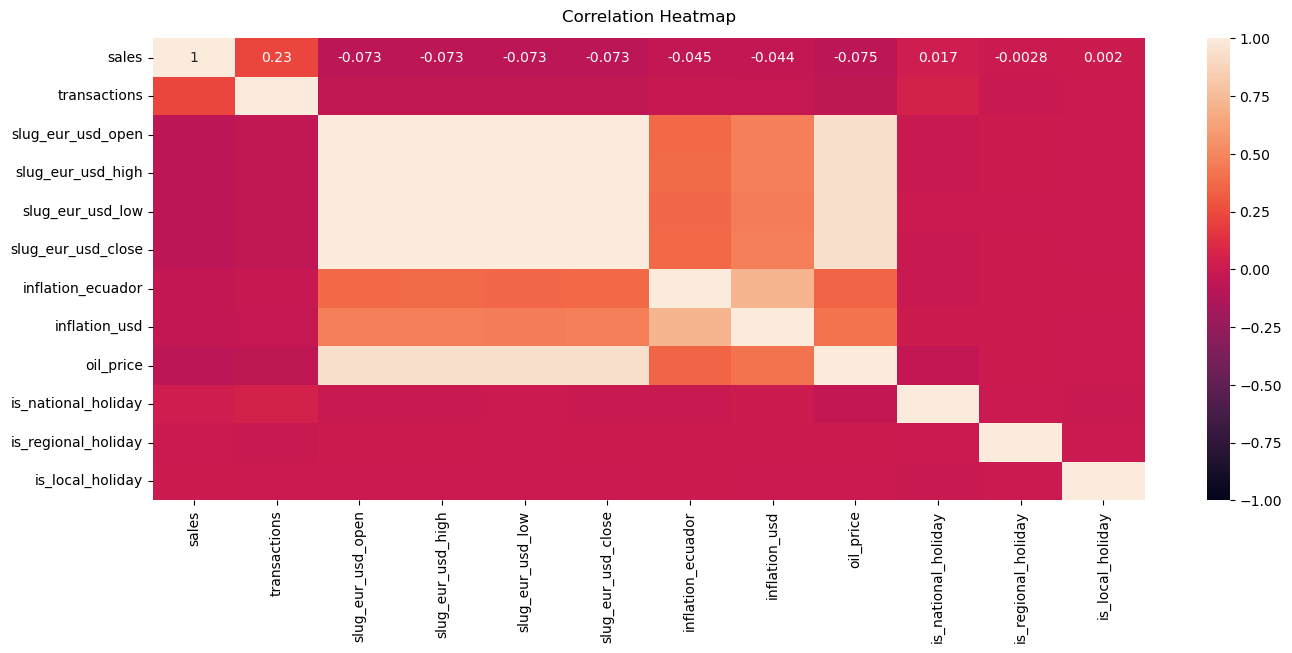

In [51]:
temp = holiday_merged_train.copy()
temp = temp[["sales", "transactions", "slug_eur_usd_open", "slug_eur_usd_high", "slug_eur_usd_low", "slug_eur_usd_close", "inflation_ecuador", "inflation_usd", "oil_price", "is_national_holiday", "is_regional_holiday", "is_local_holiday"]]
corr_df = temp.corr()
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(corr_df, vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
display(heatmap)

### Filtering out rows with unopened stores

Creating new column called open. Its 0 if the previous value in the column and the total sales on the current date are also 0, else it returns 1

In [52]:
holiday_merged_train['total_sales'] = holiday_merged_train.groupby(['date', 'store_nbr'])['sales'].transform('sum')
holiday_merged_train['open'] = holiday_merged_train.apply(lambda x: 0 if x['total_sales'] == 0 else 1 if x.name == 0 else (0 if (x['total_sales'] == 0 and holiday_merged_train.at[x.name - 1, 'open'] == 0) else 1), axis=1)
print(holiday_merged_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054876 entries, 0 to 3054875
Data columns (total 24 columns):
 #   Column               Dtype         
---  ------               -----         
 0   id                   int64         
 1   date                 datetime64[ns]
 2   store_nbr            int64         
 3   family               object        
 4   sales                float64       
 5   onpromotion          int64         
 6   city                 object        
 7   state                object        
 8   type                 object        
 9   cluster              int64         
 10  transactions         int32         
 11  slug_eur_usd_open    float64       
 12  slug_eur_usd_high    float64       
 13  slug_eur_usd_low     float64       
 14  slug_eur_usd_close   float64       
 15  inflation_ecuador    float64       
 16  inflation_usd        float64       
 17  oil_price            float64       
 18  is_national_holiday  int32         
 19  is_regional_holiday  

### Filter out closed stores

In [53]:
opened_merged_train = holiday_merged_train[holiday_merged_train["open"]==1]
opened_merged_train = opened_merged_train.drop(columns=["total_sales", "open"])
print(opened_merged_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2809653 entries, 792 to 3054875
Data columns (total 22 columns):
 #   Column               Dtype         
---  ------               -----         
 0   id                   int64         
 1   date                 datetime64[ns]
 2   store_nbr            int64         
 3   family               object        
 4   sales                float64       
 5   onpromotion          int64         
 6   city                 object        
 7   state                object        
 8   type                 object        
 9   cluster              int64         
 10  transactions         int32         
 11  slug_eur_usd_open    float64       
 12  slug_eur_usd_high    float64       
 13  slug_eur_usd_low     float64       
 14  slug_eur_usd_close   float64       
 15  inflation_ecuador    float64       
 16  inflation_usd        float64       
 17  oil_price            float64       
 18  is_national_holiday  int32         
 19  is_regional_holiday  int

### Rename columns after Nixtla standard and create unique_id column

In [54]:
renamed_merge_train = opened_merged_train.rename(columns={"date":"ds", "sales":"y"})
renamed_merge_train["unique_id"] = renamed_merge_train["store_nbr"].astype(str) + "_" + renamed_merge_train["family"]
print(renamed_merge_train.columns)

Index(['id', 'ds', 'store_nbr', 'family', 'y', 'onpromotion', 'city', 'state',
       'type', 'cluster', 'transactions', 'slug_eur_usd_open',
       'slug_eur_usd_high', 'slug_eur_usd_low', 'slug_eur_usd_close',
       'inflation_ecuador', 'inflation_usd', 'oil_price',
       'is_national_holiday', 'is_regional_holiday', 'is_local_holiday',
       'is_holiday', 'unique_id'],
      dtype='object')


### One-Hot-Encode categorical values

In [55]:
encoded_merged_train = pd.get_dummies(renamed_merge_train, columns=['store_nbr', 'family', 'city', 'state'])
display(encoded_merged_train)

,id,ds,y,onpromotion,type,cluster,transactions,slug_eur_usd_open,slug_eur_usd_high,slug_eur_usd_low,...,state_Guayas,state_Imbabura,state_Loja,state_Los Rios,state_Manabi,state_Pastaza,state_Pichincha,state_Santa Elena,state_Santo Domingo de los Tsachilas,state_Tungurahua
792,561,2013-01-01,0.000,0,D,1,770,1.320132,1.322401,1.319592,...,False,False,False,False,False,False,False,True,False,False
793,562,2013-01-01,0.000,0,D,1,770,1.320132,1.322401,1.319592,...,False,False,False,False,False,False,False,True,False,False
794,563,2013-01-01,2.000,0,D,1,770,1.320132,1.322401,1.319592,...,False,False,False,False,False,False,False,True,False,False
795,564,2013-01-01,810.000,0,D,1,770,1.320132,1.322401,1.319592,...,False,False,False,False,False,False,False,True,False,False
796,565,2013-01-01,0.000,0,D,1,770,1.320132,1.322401,1.319592,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054871,3000751,2017-08-15,59.619,0,C,3,802,1.177704,1.179245,1.168900,...,False,False,False,False,True,False,False,False,False,False
3054872,3000752,2017-08-15,94.000,0,C,3,802,1.177704,1.179245,1.168900,...,False,False,False,False,True,False,False,False,False,False
3054873,3000753,2017-08-15,915.371,76,C,3,802,1.177704,1.179245,1.168900,...,False,False,False,False,True,False,False,False,False,False
3054874,3000754,2017-08-15,0.000,0,C,3,802,1.177704,1.179245,1.168900,...,False,False,False,False,True,False,False,False,False,False


In [56]:
display(encoded_merged_train["unique_id"].nunique())

print(opened_merged_train["family"].nunique())
print(opened_merged_train["store_nbr"].nunique())

# for unique_id in encoded_merged_train["unique_id"].sort_values().unique():
#     print(unique_id)

1782

33
54


### Split dataframe by type and cluster

In [57]:
split_dataframe_dict = {}
split_dataframe_dict["unsplit_dataframe"] = encoded_merged_train.drop(columns=["type", "cluster"])

for type_value in encoded_merged_train["type"].unique():
    split_dataframe_dict[f"type_{type_value}"] = encoded_merged_train[encoded_merged_train["type"] == type_value].drop(columns=["type", "cluster"])

for cluster_value in encoded_merged_train["cluster"].unique():
    split_dataframe_dict[f"cluster_{cluster_value}"] = encoded_merged_train[encoded_merged_train["cluster"] == cluster_value].drop(columns=["type", "cluster"])

print(len(split_dataframe_dict))

23


In [58]:
import pandas as pd
import numpy as np

# Create a list of unique_ids
unique_ids = ['id1', 'id2', 'id3', 'id4']

# Create a list of infinite floats
rsmle_values = [float('inf')] * len(unique_ids)

# Create the dataframe
df = pd.DataFrame({'unique_id': unique_ids, 'rsmle': rsmle_values})

# Display the dataframe
print(df)


  unique_id  rsmle
0       id1    inf
1       id2    inf
2       id3    inf
3       id4    inf


In [59]:
best_model_per_unique_id = {}
for unique_id in encoded_merged_train["unique_id"].unique():
    best_model_per_unique_id[unique_id] = {"error": float('inf'), "prediction": pd.DataFrame(), "params": {}}

In [93]:
from window_ops.rolling import rolling_mean, rolling_max, rolling_min
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

def month_start_or_end(dates):
    """Date is month start or month end"""
    return dates.is_month_start | dates.is_month_end

def is_saturday(dates):
    """Date is monday"""
    return dates.dayofweek == 5

def run_forecast(train, valid, h, config, model):
    if model == "XGBRegressor":
        models = [XGBRegressor(random_state=42,
                               n_estimators=config["n_estimators"],
                               learning_rate=config["learning_rate"],
                               max_depth=config["max_depth"],
                               colsample_bytree=config["colsample_bytree"],
                               reg_lambda=config["reg_lambda"]
                               )]
    elif model == "LGBMRegressor":
        models = [LGBMRegressor(random_state=42,
                                n_estimators=config["n_estimators"],
                                learning_rate=config["learning_rate"],
                                max_depth=config["max_depth"],
                                num_leaves=config["num_leaves"],
                                min_data_in_leaf=config["min_data_in_leaf"],
                                bagging_fractiong=config["bagging_fraction"],
                                colsample_bytree=config["colsample_bytree"],
                                lambda_l2=config["lambda_l2"],
                                verbose=-1
                                )]

    mlfc = mlforecast.MLForecast(models=models,
                    freq='D',
                    lags=[1,7,config["lags"]],
                    lag_transforms={
                        1: [(rolling_mean, 4), (rolling_min, 4), (rolling_max, 4)],
                    },
                    date_features=['week', 'month', 'dayofweek', 'dayofyear', is_saturday, month_start_or_end],
                    num_threads=8)
    
    mlfc.fit(train, max_horizon=h)
    prediction = mlfc.predict(h=h)

    merged_prediction = pd.merge(valid, prediction, on=["ds", "unique_id"], how="inner")

    return merged_prediction



In [94]:
def champion_callback(study, frozen_trial):
    """
    Logging callback that will report when a new trial iteration improves upon existing
    best trial values.

    Note: This callback is not intended for use in distributed computing systems such as Spark
    or Ray due to the micro-batch iterative implementation for distributing trials to a cluster's
    workers or agents.
    The race conditions with file system state management for distributed trials will render
    inconsistent values with this callback.
    """

    winner = study.user_attrs.get("winner", None)

    if study.best_value and winner != study.best_value:
        study.set_user_attr("winner", study.best_value)
        if winner:
            improvement_percent = (abs(winner - study.best_value) / study.best_value) * 100
            print(
                f"Trial {frozen_trial.number} achieved value: {frozen_trial.value} with "
                f"{improvement_percent: .4f}% improvement"
            )
        else:
            print(f"Initial trial {frozen_trial.number} achieved value: {frozen_trial.value}")

In [95]:
import optuna
from sklearn.metrics import mean_squared_log_error, mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import re
from time import time
from datetime import datetime



model = "XGBRegressor"

optuna.logging.set_verbosity(optuna.logging.ERROR)

error_df = pd.DataFrame({
    "unique_id": encoded_merged_train["unique_id"].unique(), 
    "msle": [float('inf')] * len(encoded_merged_train["unique_id"].unique()),
    "mse": [float('inf')] * len(encoded_merged_train["unique_id"].unique()),
    "mae": [float('inf')] * len(encoded_merged_train["unique_id"].unique()),
    "r2": [float('inf')] * len(encoded_merged_train["unique_id"].unique()),
    "mape": [float('inf')] * len(encoded_merged_train["unique_id"].unique())
    })
best_predictions_df = pd.DataFrame()
    
for key, dataframe in split_dataframe_dict.items():

    print("current dataframe: " + key)
    start = time()

    dataframe.columns = [re.sub(r'\W+', '', col) for col in dataframe.columns]

    splitting_date = "2017.08.01"
    train = dataframe[dataframe["ds"] < splitting_date]
    valid = dataframe[dataframe["ds"] >= splitting_date]
    h = valid["ds"].nunique()

    def objective(trial):
        config = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
            "learning_rate": trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 10.0),
            "num_leaves": trial.suggest_int("num_leaves", 2, 50),
            "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 50),
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.1, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
            "lambda_l2": trial.suggest_float("lambda_l2", 0.1, 10.0),
            "lags": trial.suggest_int("lags", 14, 56, step=7)
        }

        prediction = run_forecast(train, valid, h, config, model)
        prediction.loc[prediction[model] < 0, model] = 0
        error = mean_squared_log_error(prediction['y'], prediction[model])
        
        return error

    study = optuna.create_study(direction="minimize", storage="sqlite:///C:/Users/felsp/Documents/Studium/Master/Forecasting/ForecastingUniProject/db.sqlite3", 
                                study_name=f"SUN_{model}_{key}", load_if_exists=True)
    study.optimize(objective, n_trials=25, callbacks=[champion_callback])

    prediction = run_forecast(train, valid, h, study.best_params, model)

    for unique_id in prediction["unique_id"].unique():
        if study.best_value < error_df[error_df["unique_id"] == unique_id]["msle"].iloc[0]:
            filtered_rows = prediction[prediction["unique_id"] == unique_id]
            try:
                best_predictions_df = best_predictions_df.drop(best_predictions_df[best_predictions_df["unique_id"] == unique_id].index, axis=0)
            except:
                print("Wasn't able to drop rows")
            best_predictions_df = pd.concat([best_predictions_df, filtered_rows], ignore_index=True)

            error_df.loc[error_df["unique_id"] == unique_id, "msle"] = study.best_value
            error_df.loc[error_df["unique_id"] == unique_id, "mse"] = mean_squared_error(prediction['y'], prediction[model])
            error_df.loc[error_df["unique_id"] == unique_id, "mae"] = mean_absolute_error(prediction['y'], prediction[model])
            error_df.loc[error_df["unique_id"] == unique_id, "r2"] = r2_score(prediction['y'], prediction[model])
            error_df.loc[error_df["unique_id"] == unique_id, "mape"] = mean_absolute_percentage_error(prediction['y'], prediction[model])

    print(f"Time: {(time()-start)/60}")
    

current_datetime = datetime.now()
formatted_datetime = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")

best_predictions_df.to_parquet(f"C:/Users/felsp/Documents/Studium/Master/Forecasting/ForecastingUniProject/results/prediction_dfs/prediction_{model}_{formatted_datetime}.parquet")
error_df.to_parquet(f"C:/Users/felsp/Documents/Studium/Master/Forecasting/ForecastingUniProject/results/prediction_dfs/error_{model}_{formatted_datetime}.parquet")

current dataframe: unsplit_dataframe
Initial trial 0 achieved value: 1.2386960172403347
Trial 1 achieved value: 0.6957742198827581 with  78.0313% improvement
Trial 3 achieved value: 0.5641036673866613 with  23.3416% improvement
Trial 14 achieved value: 0.2842993604020939 with  98.4189% improvement
Wasn't able to drop rows
Time: 454.7868724544843
current dataframe: type_D
Initial trial 0 achieved value: 3.9234042091589862
Trial 1 achieved value: 1.7439071571178915 with  124.9778% improvement
Trial 3 achieved value: 0.26905007062928527 with  548.1720% improvement
Trial 8 achieved value: 0.22333539445141848 with  20.4691% improvement
Trial 13 achieved value: 0.2167877261842652 with  3.0203% improvement
Time: 154.99811761379243
current dataframe: type_B
Initial trial 0 achieved value: 2.415318808429226
Trial 1 achieved value: 0.36163659195461134 with  567.8856% improvement
Trial 22 achieved value: 0.34990243994341 with  3.3535% improvement
Time: 64.17602422634761
current dataframe: type_C


In [82]:
display(filtered_rows)

,id,ds,y,onpromotion,transactions,slug_eur_usd_open,slug_eur_usd_high,slug_eur_usd_low,slug_eur_usd_close,inflation_ecuador,...,state_Guayas,state_Imbabura,state_Loja,state_LosRios,state_Manabi,state_Pastaza,state_Pichincha,state_SantaElena,state_SantoDomingodelosTsachilas,state_Tungurahua
2215,1951,2013-01-02,0.0,0,2002,1.319784,1.329805,1.319435,1.319784,2.7,...,False,False,False,False,False,False,False,False,False,False
3997,3733,2013-01-03,0.0,0,1823,1.318392,1.318913,1.308900,1.318218,2.7,...,False,False,False,False,False,False,False,False,False,False
5779,5515,2013-01-04,0.0,0,1641,1.303101,1.306380,1.300052,1.303271,2.7,...,False,False,False,False,False,False,False,False,False,False
7561,7297,2013-01-05,0.0,0,2052,1.303101,1.306380,1.300052,1.303271,2.7,...,False,False,False,False,False,False,False,False,False,False
9343,9079,2013-01-06,0.0,0,1313,1.303101,1.306380,1.300052,1.303271,2.7,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3046399,2992147,2017-08-11,0.0,0,1072,1.176997,1.183180,1.174922,1.177024,0.4,...,False,False,False,False,False,False,False,False,False,False
3048181,2993929,2017-08-12,0.0,0,1359,1.176997,1.183180,1.174922,1.177024,0.4,...,False,False,False,False,False,False,False,False,False,False
3049963,2995711,2017-08-13,0.0,0,803,1.176997,1.183180,1.174922,1.177024,0.4,...,False,False,False,False,False,False,False,False,False,False
3051745,2997493,2017-08-14,0.0,0,1293,1.182634,1.183999,1.177329,1.182550,0.4,...,False,False,False,False,False,False,False,False,False,False


NameError: name 'valid' is not defined

In [81]:
display(best_predictions_df["unique_id"].nunique())

display(best_predictions_df)

594

,id,ds,y,onpromotion,transactions,slug_eur_usd_open,slug_eur_usd_high,slug_eur_usd_low,slug_eur_usd_close,inflation_ecuador,...,state_Imbabura,state_Loja,state_LosRios,state_Manabi,state_Pastaza,state_Pichincha,state_SantaElena,state_SantoDomingodelosTsachilas,state_Tungurahua,LGBMRegressor
0,2974158,2017-08-01,5.0,0,1795,1.182355,1.183754,1.179106,1.182410,0.4,...,False,False,False,False,False,True,False,False,False,9.990755
1,2975940,2017-08-02,4.0,0,1892,1.180930,1.186760,1.179496,1.181126,0.4,...,False,False,False,False,False,True,False,False,False,14.506910
2,2977722,2017-08-03,3.0,0,1726,1.185143,1.189485,1.183400,1.185115,0.4,...,False,False,False,False,False,True,False,False,False,11.078126
3,2979504,2017-08-04,8.0,0,1847,1.188778,1.189100,1.173695,1.188495,0.4,...,False,False,False,False,False,True,False,False,False,14.520267
4,2981286,2017-08-05,5.0,0,1251,1.188778,1.189100,1.173695,1.188495,0.4,...,False,False,False,False,False,True,False,False,False,7.702453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8905,2993594,2017-08-11,8.0,4,1272,1.176997,1.183180,1.174922,1.177024,0.4,...,False,False,False,True,False,False,False,False,False,2.500881
8906,2995376,2017-08-12,6.0,0,1212,1.176997,1.183180,1.174922,1.177024,0.4,...,False,False,False,True,False,False,False,False,False,4.376408
8907,2997158,2017-08-13,9.0,0,1164,1.176997,1.183180,1.174922,1.177024,0.4,...,False,False,False,True,False,False,False,False,False,6.056607
8908,2998940,2017-08-14,9.0,0,895,1.182634,1.183999,1.177329,1.182550,0.4,...,False,False,False,True,False,False,False,False,False,3.663102


In [82]:
px.scatter(best_predictions_df, x=model, y="y", title=f"Comparison of actuals vs best predicions per unique_id for {model}", opacity=0.2, trendline="ols", trendline_color_override="red")

### Der Code hier unter wird noch nicht verwendet, ist für feature_importance gedacht

In [ ]:
from window_ops.rolling import rolling_mean, rolling_max, rolling_min
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

def month_start_or_end(dates):
    """Date is month start or month end"""
    return dates.is_month_start | dates.is_month_end

def is_saturday(dates):
    """Date is monday"""
    return dates.dayofweek == 5

def get_feature_importance(train, valid, h, config, model):
    if model == "XGBRegressor":
        models = [XGBRegressor(random_state=42,
                               n_estimators=config["n_estimators"],
                               learning_rate=config["learning_rate"],
                               max_depth=config["max_depth"],
                               colsample_bytree=config["colsample_bytree"],
                               reg_lambda=config["reg_lambda"]
                               )]
    elif model == "LGBMRegressor":
        models = [LGBMRegressor(random_state=42,
                                n_estimators=config["n_estimators"],
                                learning_rate=config["learning_rate"],
                                max_depth=config["max_depth"],
                                num_leaves=config["num_leaves"],
                                min_data_in_leaf=config["min_data_in_leaf"],
                                bagging_fractiong=config["bagging_fraction"],
                                colsample_bytree=config["colsample_bytree"],
                                lambda_l2=config["lambda_l2"],
                                verbose=-1
                                )]

    mlfc = mlforecast.MLForecast(models=models,
                    freq='D',
                    lags=[1,7,config["lags"]],
                    lag_transforms={
                        1: [(rolling_mean, 4), (rolling_min, 4), (rolling_max, 4)],
                    },
                    date_features=['week', 'month', 'dayofweek', 'dayofyear', is_saturday, month_start_or_end],
                    num_threads=8)
    
    prep_df = mlfc.preprocess(train)
    

    merged_prediction = pd.merge(valid, prediction, on=["ds", "unique_id"], how="inner")

    return merged_prediction



What to do next:

- Analyse verschiedener Modelle
- Guten plot einbauen der forecast zeigt
- Cross Validation einbauen
- Feature Importance einbauen
- Future Leakage Fix einbauen

Ideen für Feature Importance:
- Datensatz mit mlfc.preprocess(train) nur vorbereiten, nicht trainieren oder predicten
- Datensatz anschauen und überprüfen ob wie erwartet
- Datensatz direkt in LightGBM geben und da trainieren und predicten
- Prediction results mit Erwarteten Wert von MLForecast Training vergleichen
- Wenn gleich, dann lgb.plot_importance() machen und anschauen
- Am besten wäre es, wenn wir an die Daten direkt tabelarisch rankommen würden anstatt nur nen plot zu kriegen, damit wir selbst wieder One-Hot-Encodete features aufsummieren können
- Sowohl gain als auch split mal anschauen
- Gleiches für XGBoost einrichten

Idee für Plot:
- Daten für ein paar unique_ids rausfiltern
- Diese daten dann als Lineplot für y plotten
- Darüber dann die prediction legen

Idee für cross validation:
- Idk, einfach versuchen das iwi mit mlforecast cross validator durchzuboxen